In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import warnings
warnings.filterwarnings('ignore')

from modules import *

In [12]:
exp_path = './results/exp_0'

In [13]:
# load net
net = torch.load(os.path.join(exp_path, f'net.pth'))

# set environmnet
env = MetaLearningWrapper(ImmediateSerialRecallEnv())
# env = ImmediateSerialRecallEnv()

# load data
simulator = Simulator(net = net, env = env)
simulator.load_data(os.path.join(exp_path, f'data_simulation.p'))
num_trial = len(simulator.data['items'])
print('Keys:', simulator.data.keys())

Keys: dict_keys(['items', 'action_seqs', 'hidden_seqs'])


In [14]:
accuracies = []

for i in range(num_trial):
    items_ep, action_seq_ep = simulator.pull(
        i, 'items', 'action_seqs'
    )

    accuracies.append((items_ep == action_seq_ep[-env.num_items:]).all())

print('mean accuracy: %.4f' % np.mean(accuracies))

mean accuracy: 0.9888


In [15]:
hiddens = []
actions = []

for i in range(num_trial):
    items_ep, action_seq_ep, hidden_seq_ep = simulator.pull(
        i, 'items', 'action_seqs', 'hidden_seqs'
    )

    if (items_ep == action_seq_ep[-env.num_items:]).all():
        hiddens.append(hidden_seq_ep[env.num_items + env.t_delay - 1])
        actions.append(action_seq_ep[-env.num_items:])

hiddens = np.array(hiddens)
actions = np.array(actions)

In [16]:
Y = []
X = []

for i in range(len(hiddens)):
    Y.append(hiddens[i])
        
    x = np.zeros(env.num_items * env.num_targets)
    for k in range(env.num_items):
        x[env.num_targets * k + actions[i, k]] = 1
    X.append(x)

Y = np.array(Y)
X = np.array(X)

print(X.shape)
print(Y.shape)

(9888, 18)
(9888, 32)


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

betas = np.zeros((X.shape[1], Y.shape[1]))

for i in range(Y.shape[1]):
    # model = LinearRegression()
    model = Ridge(alpha = 0.1)
    model.fit(X, Y[:, i])
    betas[:, i] = model.coef_

betas.shape

(18, 32)

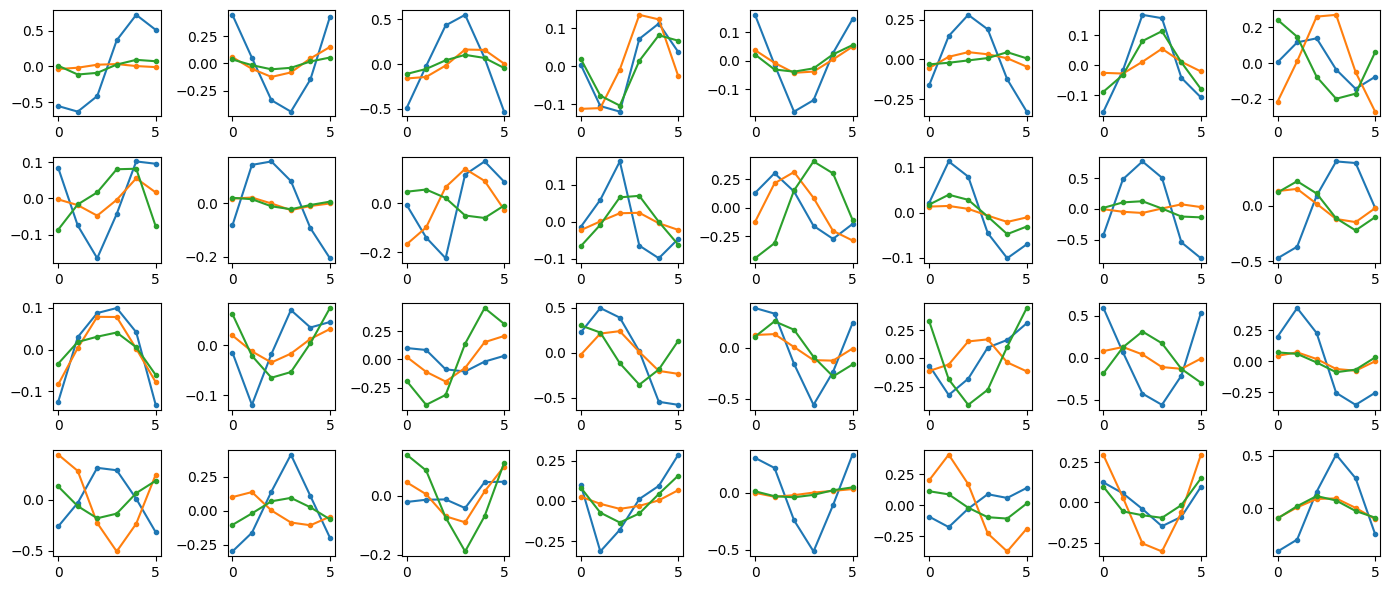

In [18]:
plt.figure(figsize = (14, 6))

count = 0
for i in range(32):
    count += 1
    plt.subplot(4, 8, count)
    for k in range(env.num_items):
        plt.plot(betas[k * env.num_targets : (k + 1) * env.num_targets, i], marker = 'o', markersize = 3)
    # plt.ylim((betas.min(), betas.max()))
    # plt.xticks([])
    # plt.yticks([])

plt.tight_layout()
plt.show()

In [19]:
from sklearn.decomposition import PCA

# divide into 3 groups (rank-r subspaces)
group_size = 6
beta_groups = [betas[i * group_size : (i + 1) * group_size] for i in range(3)]

Vr_hat_list = []
Vr_list = []
kappa_list = []

for r, beta_group in enumerate(beta_groups):
    # demean beta
    beta_mean = np.mean(beta_group, axis = 0) # (6, 32)
    beta_demeaned = beta_group - beta_mean  # (6, 32)

    # PCA
    pca = PCA(n_components = 2)
    pca.fit(beta_demeaned)
    Vr_hat = pca.components_.T # (32, 2), norm = 1
    Vr = Vr_hat * np.sqrt(Vr_hat.shape[0])
    kappa = np.dot(beta_demeaned, Vr) # (6, 2)

    # store results
    Vr_hat_list.append(Vr_hat)
    Vr_list.append(Vr)
    kappa_list.append(kappa)

# output the normalized components V̂r and the projections κ(r, l)
for r, (Vr_hat, kappa) in enumerate(zip(Vr_hat_list, kappa_list), start = 1):
    print(f"Rank-{r} Normalized Basis (V̂r):\n", Vr_hat)
    print(f"Rank-{r} Projected Coordinates (κ(r, l)):\n", kappa)

Rank-1 Normalized Basis (V̂r):
 [[ 0.02189568 -0.5436101 ]
 [ 0.29965801  0.0739716 ]
 [-0.36473981 -0.04535566]
 [ 0.01622457 -0.07618677]
 [ 0.11219629 -0.00697613]
 [-0.17690729  0.08755553]
 [-0.10501694 -0.00411988]
 [-0.03289749  0.08938564]
 [ 0.07059606 -0.05347549]
 [-0.09829935  0.07486862]
 [ 0.03444521 -0.12241126]
 [-0.027883    0.0661427 ]
 [-0.00587191  0.20463078]
 [-0.0169275   0.07540704]
 [-0.46699606  0.298479  ]
 [-0.16647403 -0.27738877]
 [-0.08013129 -0.00644109]
 [-0.00213838 -0.05433019]
 [ 0.05672546  0.03789345]
 [-0.15529553  0.38403568]
 [ 0.23971299  0.20921632]
 [ 0.06772203 -0.19167849]
 [ 0.37935292  0.10314941]
 [-0.01441025  0.29757244]
 [-0.21370501 -0.00874662]
 [-0.1881855  -0.11610044]
 [ 0.01642608 -0.01854697]
 [ 0.1055922  -0.13806102]
 [ 0.25367187  0.1157683 ]
 [ 0.0024814  -0.09910825]
 [ 0.07336953  0.05265373]
 [-0.23565884 -0.20843012]]
Rank-1 Projected Coordinates (κ(r, l)):
 [[ 7.08561897  4.69843093]
 [-0.45214813  7.7569313 ]
 [-7.256

In [20]:
def compute_principal_angles(Va, Vb):
    # compute the inner product matrix
    M = np.dot(Va.T, Vb)  # (2, 2)

    # SVD
    U, singular_values, Vt = np.linalg.svd(M)

    # compute the principal angles (in degrees)
    principal_angles = np.arccos(np.clip(singular_values, -1.0, 1.0)) * (180 / np.pi)

    return principal_angles[0]

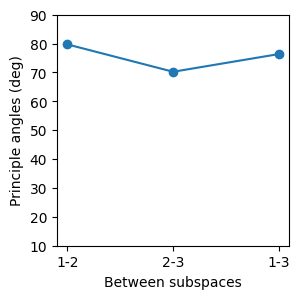

In [21]:
angles = [
    compute_principal_angles(Vr_hat_list[0], Vr_hat_list[1]),
    compute_principal_angles(Vr_hat_list[1], Vr_hat_list[2]),
    compute_principal_angles(Vr_hat_list[0], Vr_hat_list[2]),
]

plt.figure(figsize = (3, 3))
plt.plot(angles, marker = 'o')
plt.xticks(ticks = [0, 1, 2], labels = ['1-2', '2-3', '1-3'])
plt.ylim((10, 90))
plt.xlabel('Between subspaces')
plt.ylabel('Principle angles (deg)')
plt.show()

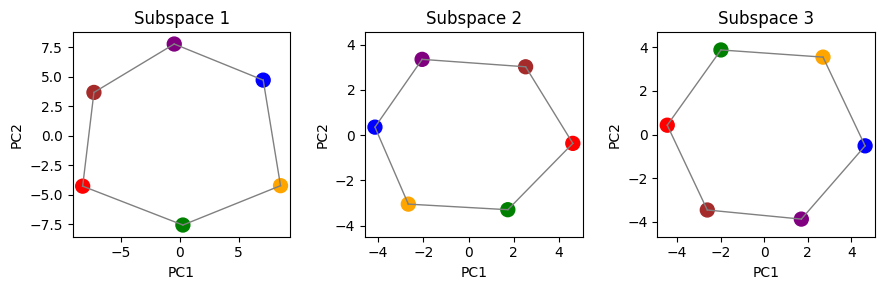

In [22]:
plt.figure(figsize = (9, 3))
for j in range(3):
    kappa = kappa_list[j]

    plt.subplot(1, 3, j + 1)
    plt.scatter(kappa[:, 0], kappa[:, 1], c = ['blue', 'purple', 'brown', 'red', 'green', 'orange'], s = 100)
    for i in range(len(kappa)):
        next_i = (i + 1) % len(kappa)
        plt.plot([kappa[i, 0], kappa[next_i, 0]], [kappa[i, 1], kappa[next_i, 1]], color = 'gray', linewidth = 1)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Subspace %.0f' % (j + 1), fontsize = 12, loc = 'center')
    # plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    # plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axis('equal')
plt.tight_layout()
plt.show()